## Training: Fitness Function

In [2]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from src.models.surrogate_model import *
from src.data.ff_dataloader import *
from src.preprocessing.transform_into_model_data_ff import *

#### Set seeds

In [ ]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)


#### Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetFF(train=True, path="../data/fitness_function")
test_dataset = DatasetFF(train=False, path="../data/fitness_function")

In [5]:
train_dataset.X

tensor([[-1.0805,  0.0947,  1.0350,  ..., -0.6708,  2.1888,  0.9412],
        [ 0.2211, -0.0712,  0.0370,  ..., -0.4407, -0.1589, -0.4204],
        [-0.3712, -1.7317,  1.3790,  ...,  0.8183, -0.7485, -1.0150],
        ...,
        [-0.5492, -0.2103, -0.3000,  ...,  0.0330, -0.8873, -2.4520],
        [-0.5709, -0.6395,  1.0082,  ...,  1.8393, -1.3611, -1.2889],
        [-0.1735,  0.7730, -0.0552,  ...,  0.3806,  0.9324, -1.3543]])

In [4]:
train_dataset.y

tensor([2, 2, 2,  ..., 4, 2, 3])

#### Scale training and test data

In [6]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:,6:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

#### Build model and switch to GPU if available

In [7]:
fitness_function = FitnessFunction(hidden_sizes=[98, 69])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=360, out_features=245, bias=True)
  )
  (out): Linear(in_features=245, out_features=5, bias=True)
)

#### Define loss function and optimizer

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fitness_function.parameters(), lr=0.001)

#### Define Data loaders

In [9]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Model training

In [10]:
n_epochs = 1000

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = fitness_function(inputs)

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    if (it + 1) % 1 == 0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 1.6281, Test Loss: 1.6300
Epoch 2/10, Train Loss: 1.4786, Test Loss: 1.6650
Epoch 3/10, Train Loss: 1.3705, Test Loss: 1.7035
Epoch 4/10, Train Loss: 1.2620, Test Loss: 1.7654
Epoch 5/10, Train Loss: 1.1376, Test Loss: 1.8314
Epoch 6/10, Train Loss: 1.0063, Test Loss: 1.8645
Epoch 7/10, Train Loss: 0.8547, Test Loss: 1.9052
Epoch 8/10, Train Loss: 0.7067, Test Loss: 1.9543
Epoch 9/10, Train Loss: 0.5590, Test Loss: 1.9948
Epoch 10/10, Train Loss: 0.4258, Test Loss: 2.0404


#### Plot the train loss and test loss per iteration

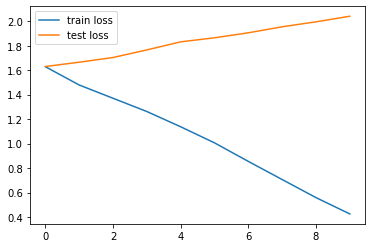

In [11]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#### Save trained model

In [18]:
torch.save(fitness_function.state_dict(), "../models/best_fitness_function.pth")

#### Load model and make predictions

In [29]:
model = FitnessFunction(hidden_sizes=[98, 69])
model.load_state_dict(torch.load("../models/best_fitness_function.pth"))
model.eval()

FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=360, out_features=245, bias=True)
  )
  (out): Linear(in_features=245, out_features=5, bias=True)
)

In [28]:
random_input = torch.from_numpy(np.random.normal(size=[1, 98]).astype(np.float32))

output = model(random_input)

tensor([[ 0.0636, -2.3131,  0.8815, -0.8085, -0.2552]],
       grad_fn=<AddmmBackward>)


tensor(2)

In [ ]:
output

In [ ]:
decode_classes(output)